In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [68]:
albums = pd.read_csv('album_details.csv')
albums.drop(columns=['Unnamed: 0','id','name','type','year'], inplace = True)
albums.head()

,singer_name
0,Taylor Swift Lyrics
1,Taylor Swift Lyrics
2,Taylor Swift Lyrics
3,Taylor Swift Lyrics
4,Taylor Swift Lyrics


In [69]:
songs = pd.read_csv('songs_details.csv')
songs.drop(columns=['Unnamed: 0','song_href','song_id'], inplace = True)
songs.head()

,singer_name,song_name
0,Taylor Swift Lyrics,Tim McGraw
1,Taylor Swift Lyrics,Picture To Burn
2,Taylor Swift Lyrics,Teardrops On My Guitar
3,Taylor Swift Lyrics,A Place In This World
4,Taylor Swift Lyrics,Cold As You


In [70]:
lyrics = pd.read_csv('lyrics.csv')
lyrics.drop(columns=['Unnamed: 0','link'], inplace = True)
lyrics.head()

,artist,song_name,lyrics
0,Backstreet Boys Lyrics,Climbing The Walls,"\n\n[Brian:]\nClose your eyes, make a wish\nTh..."
1,Westlife Lyrics,How To Break A Heart,\n\r\nSince you're not worth my love\nI haven'...
2,Dean Martin Lyrics,I Will,\n\r\nI don't want to be the one to say I'm go...
3,Dean Martin Lyrics,Tell Your Mother Hello,\n\r\nSure I loved the dear money that shines ...
4,Dean Martin Lyrics,Be Honest With Me,\n\r\nBe honest with me dear whatever you do\n...


### Lets choose the top two singers

In [71]:
albums.singer_name.value_counts()

Johnny Cash Lyrics         65
Elvis Presley Lyrics       63
Frank Sinatra Lyrics       43
Prince Lyrics              40
Bob Dylan Lyrics           39
                           ..
Wham! Lyrics                3
M2M Lyrics                  3
Yola Lyrics                 2
Chord Overstreet Lyrics     2
Lil Nas X Lyrics            2
Name: singer_name, Length: 148, dtype: int64

In [72]:
albums = albums[(albums.singer_name == 'Johnny Cash Lyrics') | (albums.singer_name == 'Frank Sinatra Lyrics')]
albums = albums.reset_index(drop = True)

### Now let's get the songs of the two singers

In [73]:
albums_songs = pd.merge(albums, songs, how="left", on=["singer_name"])
albums_songs.head()

,singer_name,song_name
0,Frank Sinatra Lyrics,You Go To My Head
1,Frank Sinatra Lyrics,Someone To Watch Over Me
2,Frank Sinatra Lyrics,These Foolish Things (Remind Me Of You)
3,Frank Sinatra Lyrics,Why Shouldn't I?
4,Frank Sinatra Lyrics,I Don't Know Why (I Just Do)


#### What about the lyrics? Notice that singer name column is named 'artist' in lyrics dataset

In [74]:
lyrics.rename(columns={'artist': "singer_name"}, inplace = True)
albums_songs = pd.merge(albums_songs, lyrics, how="left", on=["singer_name","song_name"])
albums_songs.head()

,singer_name,song_name,lyrics
0,Frank Sinatra Lyrics,You Go To My Head,\n\r\nYou go to my head\nAnd you linger like a...
1,Frank Sinatra Lyrics,You Go To My Head,\n\r\nYou go to my head\nAnd you linger like a...
2,Frank Sinatra Lyrics,Someone To Watch Over Me,\n\r\nThere's a somebody I'm longing to see\nI...
3,Frank Sinatra Lyrics,Someone To Watch Over Me,\n\r\nThere's a somebody I'm longing to see\nI...
4,Frank Sinatra Lyrics,These Foolish Things (Remind Me Of You),\n\r\nA cigarette that bears a lipstick's trac...


### Lets check how many nulls and duplicates we got and drop them

In [75]:
albums_songs.isnull().sum()

singer_name      0
song_name        0
lyrics         498
dtype: int64

In [76]:
albums_songs.duplicated().sum()

103550

In [77]:
albums_songs = albums_songs.dropna().reset_index(drop=True)
albums_songs = albums_songs.drop_duplicates().reset_index(drop=True)
albums_songs = albums_songs[~albums_songs.lyrics.duplicated(keep=False)]

# 1. Lyrics text Exploration

### Separate the lyrics on the one hand and the singer on the other

In [78]:
lyric = albums_songs.lyrics
singer = albums_songs.singer_name

In [79]:
#Print a lyric to see what it looks like
print(lyric[0])



You go to my head
And you linger like a haunting refrain
And I find you spinning round in my brain
Like the bubbles in a glass of champagne

You go to my head
Like a sip of sparkling burgundy brew
And I find the very mention of you
Like the kicker in a julep or two

The thrill of the thought
That you might give a thought to my plea, cast a spell over me
Still I say to myself get a hold of yourself
Can't you see that it never can be?

You go to my head
With a smile that makes my temperature rise
Like a summer with a thousand Julys
You intoxicate my soul with your eyes

Though I'm certain that this heart of mine
Hasn't a ghost of a chance in this crazy romance
You go to my head
You go to my head



### Create the text cleaning function:
Thiss function will clean the text to be able to continue with text processing with TF-IDF.
For this function we recommend using the re package

In [80]:
import re   
import nltk
nltk.download('stopwords')  # you have to download it the first time
from nltk.corpus import stopwords

def cleanText(lyric):   
    # Remove the expressions between braces that denote the parts of the song
    text = re.sub(r'\[.+\]', ' ', str(lyric))
    # Remove clarifications in parentheses
    text = re.sub(r'\(.+\)', ' ', str(text))
    # # Remove what are not words or something that resembles it
    text = re.sub(r'\W', ' ', text)
    # Remove extra spaces if there are
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Convert the text to lowercase
    text = text.lower()
    # remove stopwords
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    text = " ".join(text)

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\20190958\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
#Applying the function to our set of lyrics
clean_lyric = lyric.apply(cleanText)

In [82]:
# print the lyric to see the changes
print(clean_lyric[0])

go head linger like haunting refrain find spinning round brain like bubbles glass champagne go head like sip sparkling burgundy brew find mention like kicker julep two thrill thought might give thought plea cast spell still say get hold see never go head smile makes temperature rise like summer thousand julys intoxicate soul eyes though certain heart mine ghost chance crazy romance go head go head


### Lemmatization

In [83]:
from nltk.stem import WordNetLemmatizer 
  
def lemmatizeText(text):   
    #apply lemmatization
    lemmatizer = WordNetLemmatizer() 
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

### Stemming

In [84]:
from nltk.stem import PorterStemmer 
  
def stemText(text):   
    #apply stemming
    porter = PorterStemmer() 
    text = text.split()
    text = [porter.stem(word) for word in text]
    text = " ".join(text)
    return text

#### Lets see the differences

In [85]:
# with neither lemmatization nor stemming
print(clean_lyric[0])

go head linger like haunting refrain find spinning round brain like bubbles glass champagne go head like sip sparkling burgundy brew find mention like kicker julep two thrill thought might give thought plea cast spell still say get hold see never go head smile makes temperature rise like summer thousand julys intoxicate soul eyes though certain heart mine ghost chance crazy romance go head go head


In [86]:
# with lemmatization only
print(lemmatizeText(clean_lyric[0]))

go head linger like haunting refrain find spinning round brain like bubble glass champagne go head like sip sparkling burgundy brew find mention like kicker julep two thrill thought might give thought plea cast spell still say get hold see never go head smile make temperature rise like summer thousand july intoxicate soul eye though certain heart mine ghost chance crazy romance go head go head


In [87]:
# with stemming only
print(stemText(clean_lyric[0]))

go head linger like haunt refrain find spin round brain like bubbl glass champagn go head like sip sparkl burgundi brew find mention like kicker julep two thrill thought might give thought plea cast spell still say get hold see never go head smile make temperatur rise like summer thousand juli intox soul eye though certain heart mine ghost chanc crazi romanc go head go head


### Did you see the differencec? Now lets choose one of them to proceed

In [88]:
# Choose either lemmatization or stemming for the text before going into Wordcloud
clean_lyric = clean_lyric.apply(lemmatizeText)

# 2. Wordcloud

#### Draw a wordcloud of one of the lyrics texts

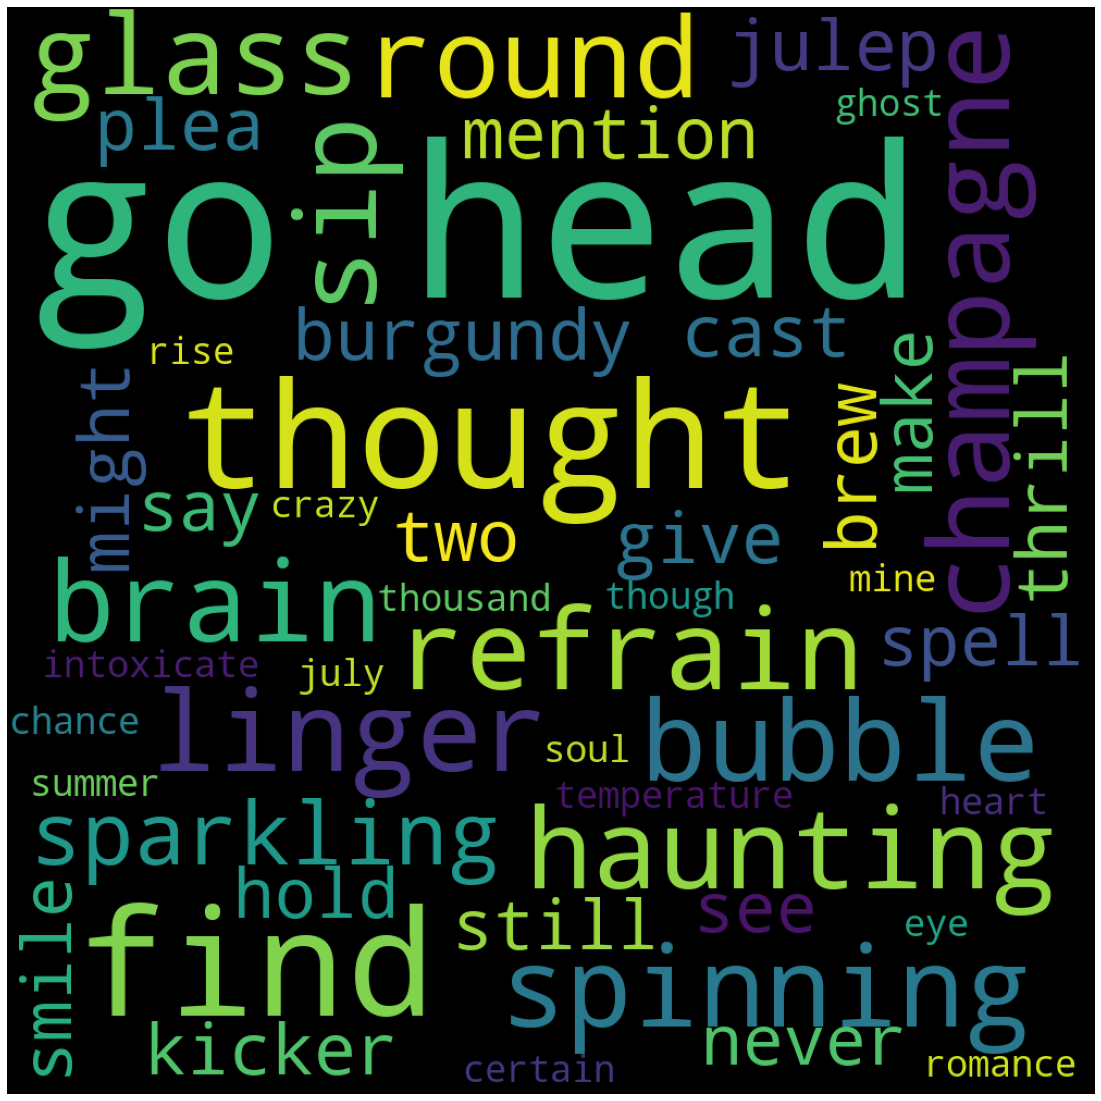

In [89]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 1000, height = 1000,min_font_size = 10).generate(str(clean_lyric[0]))
fig = plt.figure(1, figsize=(20, 20))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Lets try for all the lyric texts together

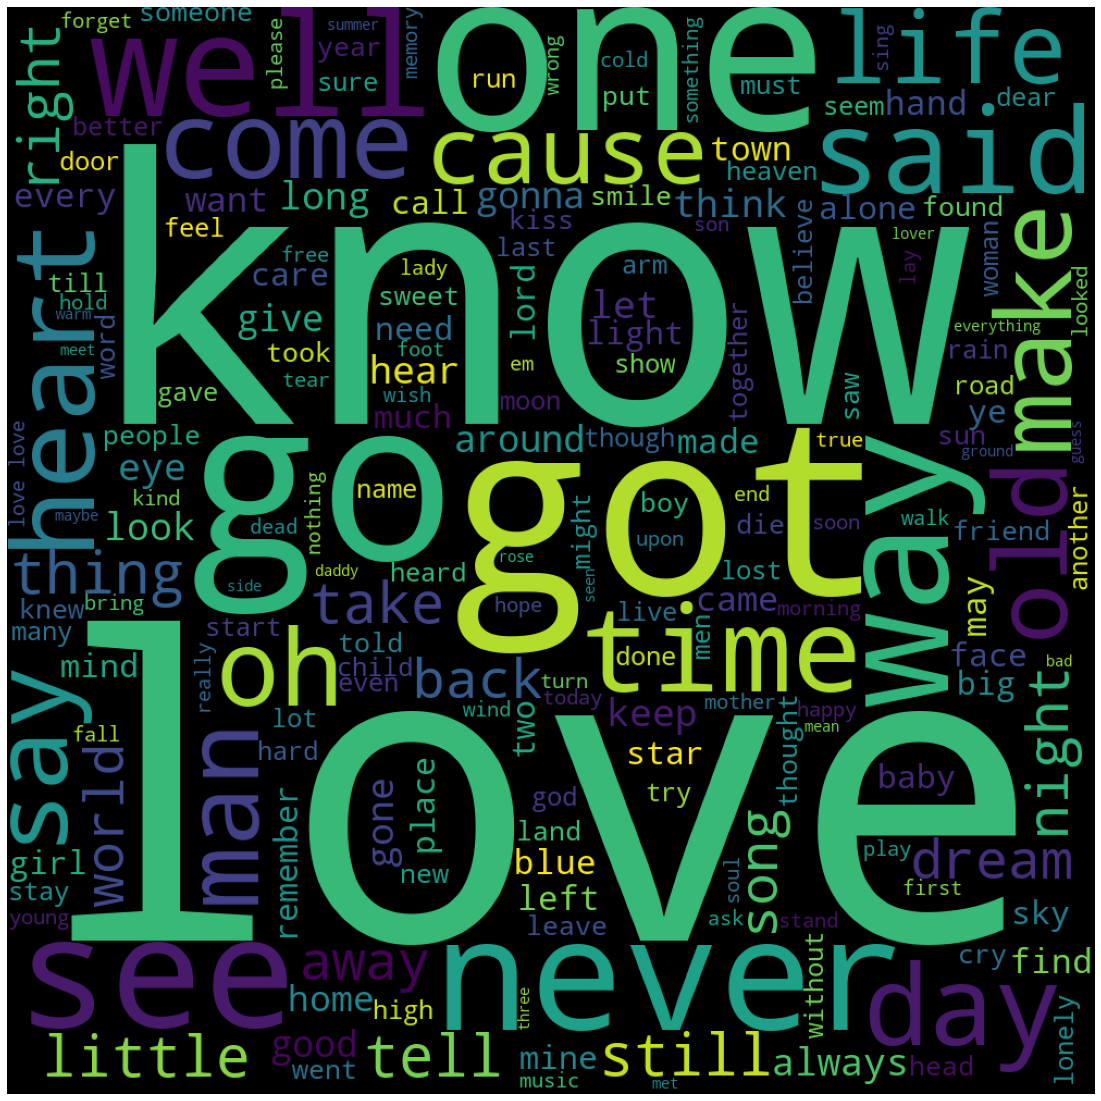

In [90]:
wordcloud = WordCloud(width = 1000, height = 1000,min_font_size = 10).generate(str(" ".join(clean_lyric)))
fig = plt.figure(1, figsize=(20, 20))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

### Can you guess the most important terms?

# 3. TF-IDF

#### We are going to transform our clean lyrics texts into matrix form using TfidfVectorizer from sklearn

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfconverter = TfidfVectorizer(max_features=100, min_df=1, max_df=0.9)
tfidfconverter.fit(clean_lyric)
X = tfidfconverter.transform(clean_lyric).toarray()

### Lets get the top terms in the lyric texts using the tf-idf matric we just created

In [92]:
feature_array = np.array(tfidfconverter.get_feature_names())
tfidf_sorting = np.argsort(X).flatten()[::-1]
n = 5
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['cause', 'baby', 'little', 'got', 'well'], dtype='<U9')

### Who missed the clustering session? Lets try some clusters here.
Lets see how many clusters we will need by... do you remember the elbow method?

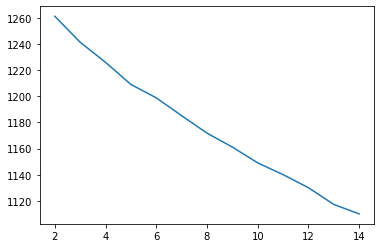

In [93]:
from sklearn.cluster import KMeans
import seaborn as sns
scores = []
k_values = range(2,15)
for a in k_values:
    kmeans = KMeans(n_clusters=a, random_state=0).fit(X)
    scores.append(kmeans.inertia_)
    
sns.lineplot(x=k_values, y=scores)

C:\Users\20190958\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


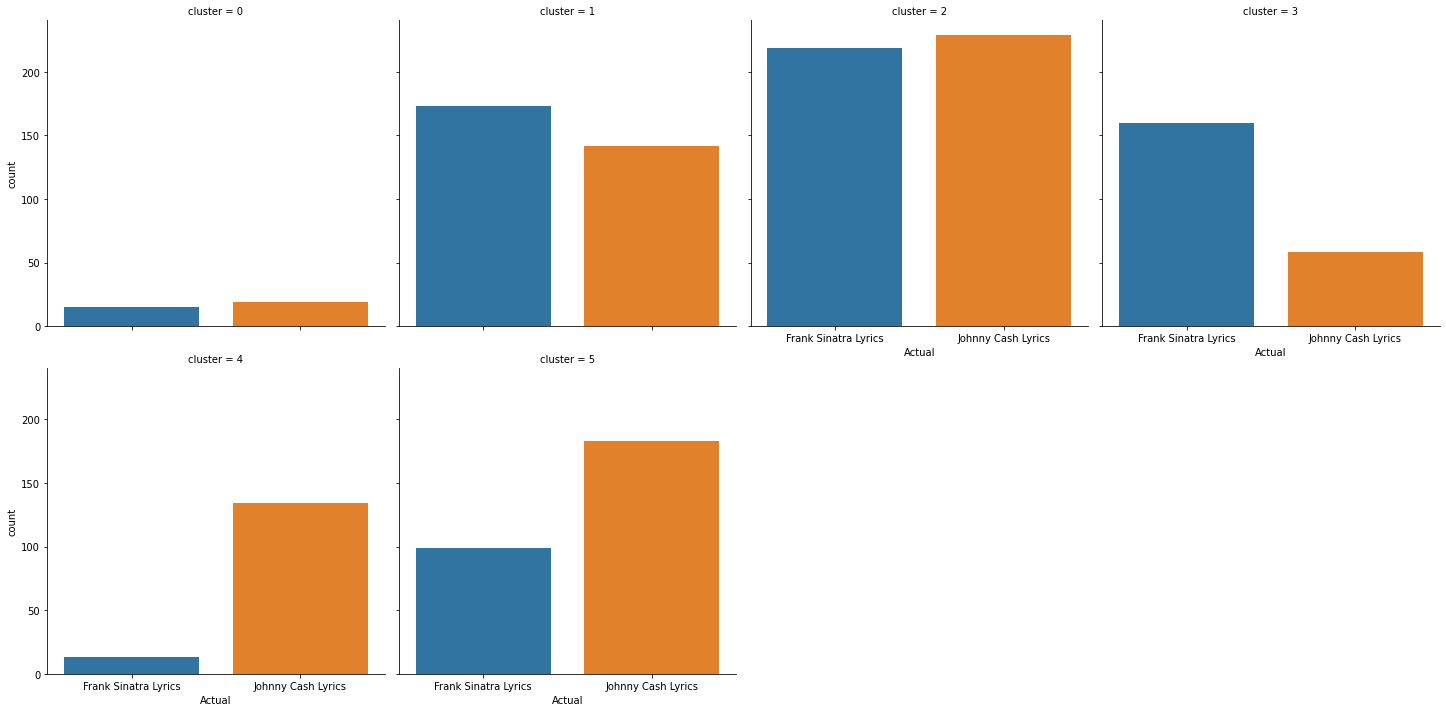

In [94]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)

# Prepare the factorplot
cluster_result = pd.DataFrame()
cluster_result['cluster'] = kmeans.predict(X)
cluster_result['Actual'] = singer

ax = sns.factorplot(col='cluster', x='Actual', data=cluster_result, kind='count',col_wrap=4)

#### Now lets plot the cluster data. Oh wait we have many features, so how can we visualize them in 2-D? Can you remember? Hint: something to do with dimensionality reduction
We need two plots: 1. A colored scatterplot with the actual labels for all the data together. 2. A scatterplot with the number of clusters that we have chosen.

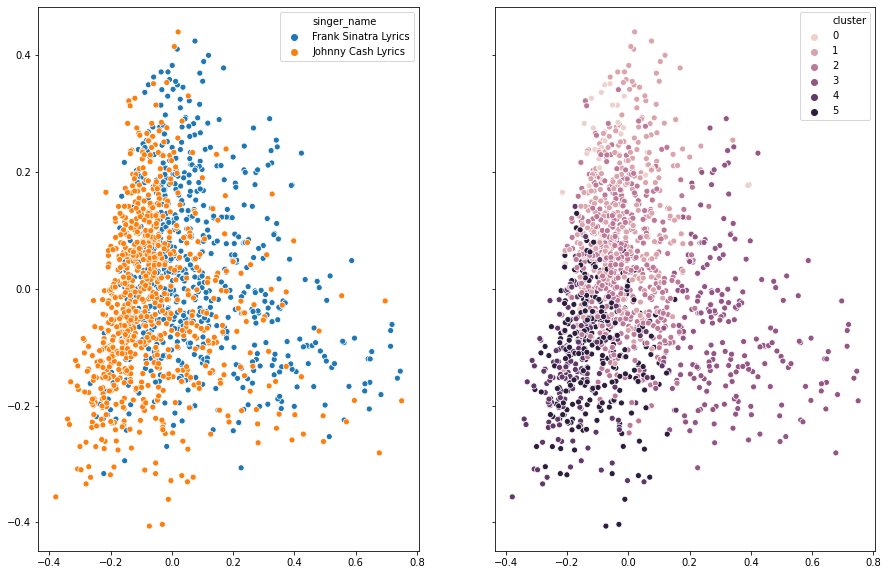

In [95]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
pintar = pca.transform(X)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,10))
plot1 = sns.scatterplot(x = pintar[:,0], y = pintar[:,1], hue = singer , legend = "full", ax = ax1)
plot2 = sns.scatterplot(x = pintar[:,0], y = pintar[:,1], hue = cluster_result['cluster'] , legend = "full", ax = ax2)

### Where are the clusters? Can you see them? Kmeans didn't help this time, so maybe a classifier can help us

# 3. Classifier

#### Step 1: splitting the data between text and train

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, singer, test_size=0.3, random_state=42)

#### Step 2: Train a classifier and get its accuracy. Do you remember what classifier we took in session 4 (Alican)?

In [97]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.7397260273972602